In [1]:
import os, glob, subprocess, datetime, ee, geemap

import pandas as pd
import geopandas as gpd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns

from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline
from matplotlib.transforms import ScaledTranslation
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from adjustText import adjust_text

from loading_utils import (_process_solar_metadata,
                           _process_wind_metadata, 
                           _process_training_curves, 
                           _process_testing_curves, 
                           _process_traning_forecasts, 
                           _process_testing_forecasts)

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams['font.family']         = 'Avenir'

path_to_fPCA   = '/Users/Guille/Desktop/dynamic_update/software/fPCA'
path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/software/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'
path_to_images = '/Users/Guille/Desktop/dynamic_update/images'

# Loading color palette
palette_ = pd.read_csv(path_to_data + '/palette.csv')
print(palette_)

# Loading Texas map
TX_    = gpd.read_file(path_to_data + '/maps/TX/State.shp')
ERCOT_ = gpd.read_file(path_to_data + '/maps/ERCOT/eia-mod-BW-ERCOT-shapefile.shp')

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN


In [7]:
T        = 288
resource = 'solar'

# Load 2017 data as training set
with open(path_to_data + f"/preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
x_tr_      = _data["locations"]
dates_tr_  = _data["dates"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, x_tr_.shape, dates_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
T_tr_ = dates_tr_.reshape(int(dates_tr_.shape[0]/T), T)
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
x_ts_      = _data["locations"]
dates_ts_  = _data["dates"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, x_ts_.shape, dates_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
T_ts_ = dates_ts_.reshape(int(dates_ts_.shape[0]/T), T)
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

dt_ = np.array([t * 5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({"time": dt_}).time, unit = "m").dt.strftime("%H:%M").to_numpy()
print(dt_.shape, dx_.shape)

# Short testing set with training set order
order      = {v: i for i, v in enumerate(assets_tr_)}
idx_       = np.argsort([order[x] for x in assets_ts_])
assets_ts_ = assets_ts_[idx_]
x_ts_      = x_ts_[idx_]
F_ts_      = F_ts_[:, :, idx_]
E_ts_      = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

F_tr_ /= np.tile(p_tr_, (F_tr_.shape[0], F_tr_.shape[1], 1))
E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
F_ts_ /= np.tile(p_ts_, (F_ts_.shape[0], F_ts_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(F_tr_.min(), F_tr_.max())
print(E_tr_.min(), E_tr_.max())
print(F_ts_.min(), F_ts_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
F_tr_[F_tr_ > 1.] = 1.
F_tr_[F_tr_ < 0.] = 0.
F_ts_[F_ts_ > 1.] = 1.
F_ts_[F_ts_ < 0.] = 0.
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
T_tr_      = np.concatenate([T_tr_ for k in range(assets_tr_.shape[0])], axis = 0)
assets_tr_ = np.concatenate([np.tile(assets_tr_[k], (F_tr_.shape[0], 1)) for k in range(assets_tr_.shape[0])], axis = 0)
x_tr_      = np.concatenate([np.tile(x_tr_[k, :], (F_tr_.shape[0], 1)) for k in range(x_tr_.shape[0])], axis = 0)
F_tr_      = np.concatenate([F_tr_[..., k] for k in range(F_tr_.shape[2])], axis = 0)
E_tr_      = np.concatenate([E_tr_[..., k] for k in range(E_tr_.shape[2])], axis = 0)
print(x_tr_.shape, assets_tr_.shape, F_tr_.shape, E_tr_.shape, T_tr_.shape)
print(x_ts_.shape, assets_ts_.shape, F_ts_.shape, E_ts_.shape, T_ts_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_tr in T_tr_[:, 0]]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_ts in T_ts_[:, 0]]) - 1
print(t_tr_.shape, t_ts_.shape)

F_ts_solar_ = F_ts_.copy()
E_ts_solar_ = E_ts_.copy()
p_ts_solar_ = p_ts_.copy()
x_ts_solar_ = x_ts_.copy()

assets_ts_solar_ = assets_ts_.copy()

(211,) (211, 2) (104544,) (104544, 211) (104544, 211)
(363, 288, 211) (363, 288, 211) (363, 288)
(211,) (211, 2) (104832,) (104832, 211) (104832, 211)
(364, 288, 211) (364, 288, 211) (364, 288)
(288,) (288,)
(364, 288, 211) (364, 288, 211) (364, 288)
(211,) (211,)
0.0 1.0
0.0 1.1666666178190028
0.0 1.0
0.0 2.1269094668054778
(76593, 2) (76593, 1) (76593, 288) (76593, 288) (76593, 288)
(211, 2) (211,) (364, 288, 211) (364, 288, 211) (364, 288)
(76593,) (364,)


In [8]:
T        = 288
resource = 'wind'

# Load 2017 data as training set
with open(path_to_data + f"/preprocessed_{resource}_2017.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_tr_ = _data["assets"]
x_tr_      = _data["locations"]
dates_tr_  = _data["dates"]
F_tr_      = _data["observations"]
E_tr_      = _data["forecasts"]
print(assets_tr_.shape, x_tr_.shape, dates_tr_.shape, F_tr_.shape, E_tr_.shape)

# Reshape to day x interval x asset format
F_tr_ = F_tr_.reshape(int(F_tr_.shape[0]/T), T, F_tr_.shape[1])
E_tr_ = E_tr_.reshape(int(E_tr_.shape[0]/T), T, E_tr_.shape[1])
T_tr_ = dates_tr_.reshape(int(dates_tr_.shape[0]/T), T)
print(F_tr_.shape, E_tr_.shape, T_tr_.shape)

# Load 2018 data as testing set
with open(path_to_data + f"/preprocessed_{resource}_2018.pkl", 'rb') as f:
    _data = pkl.load(f)

assets_ts_ = _data["assets"]
x_ts_      = _data["locations"]
dates_ts_  = _data["dates"]
F_ts_      = _data["observations"]
E_ts_      = _data["forecasts"]
print(assets_ts_.shape, x_ts_.shape, dates_ts_.shape, F_ts_.shape, E_ts_.shape)

# Reshape to day x interval x asset format
F_ts_ = F_ts_.reshape(int(F_ts_.shape[0]/T), T, F_ts_.shape[1])
E_ts_ = E_ts_.reshape(int(E_ts_.shape[0]/T), T, E_ts_.shape[1])
T_ts_ = dates_ts_.reshape(int(dates_ts_.shape[0]/T), T)
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

dt_ = np.array([t * 5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({"time": dt_}).time, unit = "m").dt.strftime("%H:%M").to_numpy()
print(dt_.shape, dx_.shape)

# Short testing set with training set order
order      = {v: i for i, v in enumerate(assets_tr_)}
idx_       = np.argsort([order[x] for x in assets_ts_])
assets_ts_ = assets_ts_[idx_]
x_ts_      = x_ts_[idx_]
F_ts_      = F_ts_[:, :, idx_]
E_ts_      = E_ts_[:, :, idx_]
print(F_ts_.shape, E_ts_.shape, T_ts_.shape)

# From generation to capacity factor
p_tr_ = np.max(np.max(F_tr_, axis = 0), axis = 0)
p_ts_ = np.max(np.max(F_ts_, axis = 0), axis = 0)
print(p_tr_.shape, p_ts_.shape)

F_tr_ /= np.tile(p_tr_, (F_tr_.shape[0], F_tr_.shape[1], 1))
E_tr_ /= np.tile(p_tr_, (E_tr_.shape[0], E_tr_.shape[1], 1))
F_ts_ /= np.tile(p_ts_, (F_ts_.shape[0], F_ts_.shape[1], 1))
E_ts_ /= np.tile(p_ts_, (E_ts_.shape[0], E_ts_.shape[1], 1))
print(F_tr_.min(), F_tr_.max())
print(E_tr_.min(), E_tr_.max())
print(F_ts_.min(), F_ts_.max())
print(E_ts_.min(), E_ts_.max())

# No possible a capacity factor is larger than 1 or smaller than 0
F_tr_[F_tr_ > 1.] = 1.
F_tr_[F_tr_ < 0.] = 0.
F_ts_[F_ts_ > 1.] = 1.
F_ts_[F_ts_ < 0.] = 0.
E_tr_[E_tr_ > 1.] = 1.
E_tr_[E_tr_ < 0.] = 0.
E_ts_[E_ts_ > 1.] = 1.
E_ts_[E_ts_ < 0.] = 0.

# Format training set from day x interval x asset to [day * asset] x interval
T_tr_      = np.concatenate([T_tr_ for k in range(assets_tr_.shape[0])], axis = 0)
assets_tr_ = np.concatenate([np.tile(assets_tr_[k], (F_tr_.shape[0], 1)) for k in range(assets_tr_.shape[0])], axis = 0)
x_tr_      = np.concatenate([np.tile(x_tr_[k, :], (F_tr_.shape[0], 1)) for k in range(x_tr_.shape[0])], axis = 0)
F_tr_      = np.concatenate([F_tr_[..., k] for k in range(F_tr_.shape[2])], axis = 0)
E_tr_      = np.concatenate([E_tr_[..., k] for k in range(E_tr_.shape[2])], axis = 0)
print(x_tr_.shape, assets_tr_.shape, F_tr_.shape, E_tr_.shape, T_tr_.shape)
print(x_ts_.shape, assets_ts_.shape, F_ts_.shape, E_ts_.shape, T_ts_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_tr in T_tr_[:, 0]]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, "%Y-%m-%d %H:%M:%S").timetuple().tm_yday 
                  for t_ts in T_ts_[:, 0]]) - 1
print(t_tr_.shape, t_ts_.shape)

F_ts_wind_ = F_ts_.copy()
E_ts_wind_ = E_ts_.copy()
p_ts_wind_ = p_ts_.copy()
x_ts_wind_ = x_ts_.copy()

assets_ts_wind_ = assets_ts_.copy()

(187,) (187, 2) (104544,) (104544, 187) (104544, 187)
(363, 288, 187) (363, 288, 187) (363, 288)
(187,) (187, 2) (104832,) (104832, 187) (104832, 187)
(364, 288, 187) (364, 288, 187) (364, 288)
(288,) (288,)
(364, 288, 187) (364, 288, 187) (364, 288)
(187,) (187,)
0.0 1.0
0.0 0.9999999888984703
0.0 1.0
0.0 1.113073847912657
(67881, 2) (67881, 1) (67881, 288) (67881, 288) (67881, 288)
(187, 2) (187,) (364, 288, 187) (364, 288, 187) (364, 288)
(67881,) (364,)


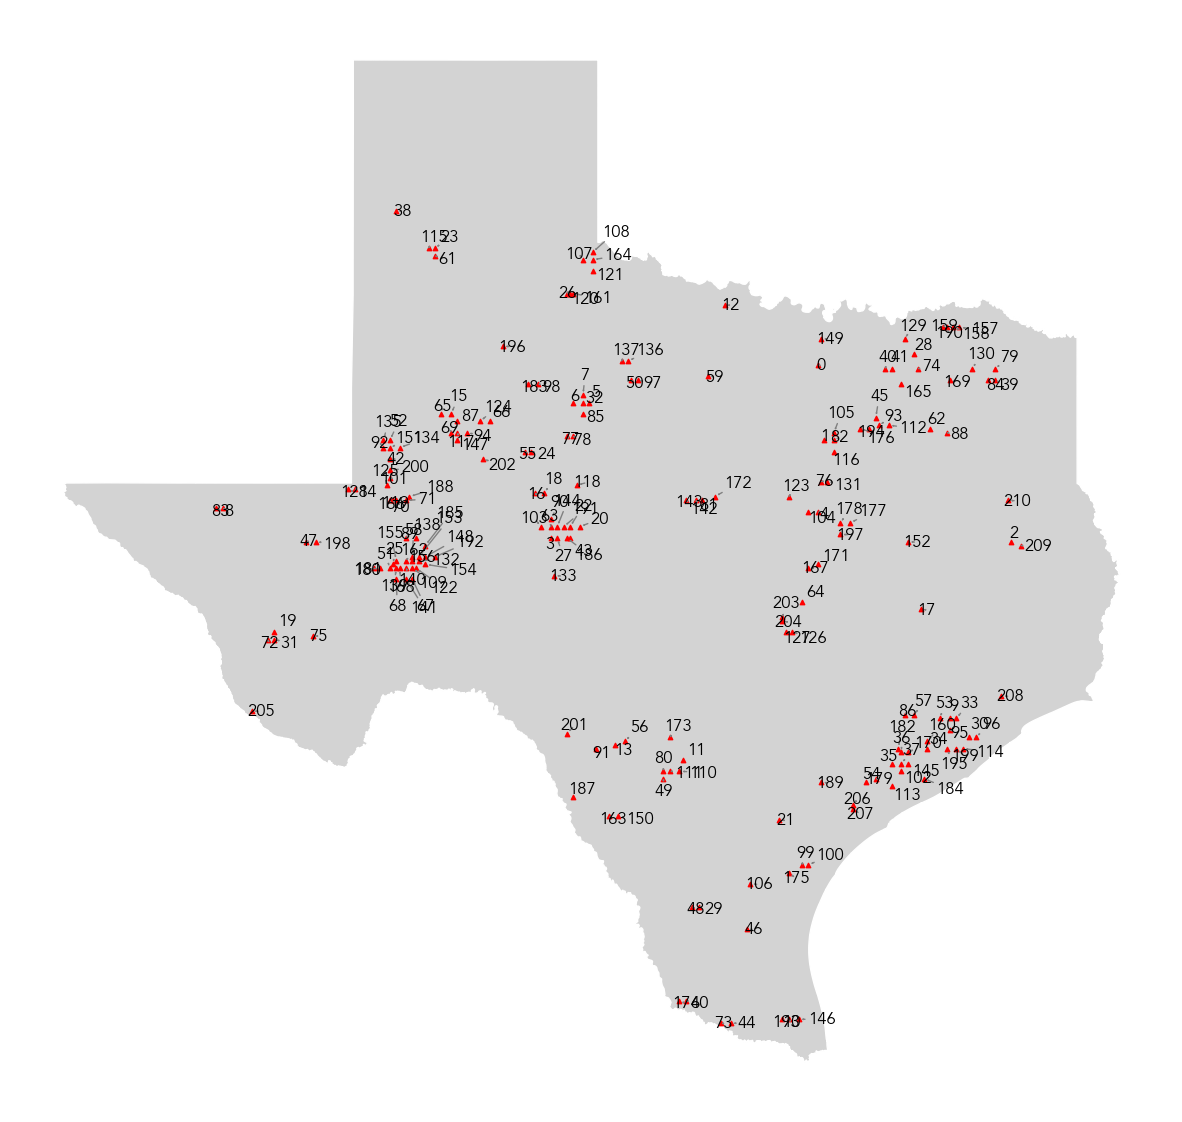

In [9]:
fig, _ax = plt.subplots(figsize = (15, 15))  # Adjust figure size as needed

TX_.plot(ax        = _ax, 
         facecolor = 'lightgray', 
         edgecolor = 'white')

_ax.scatter(x_ts_solar_[:, 0], x_ts_solar_[:, 1], s = 10., c = 'r', marker = '^')


# Create annotation texts
labels_ = [f'{assets_ts_solar_[i]}' for i in range(assets_ts_solar_.shape[0])]
labels_ = [f'{i}' for i in range(assets_ts_solar_.shape[0])]
texts_  = [_ax.text(x_ts_solar_[i, 0], x_ts_solar_[i, 1], label, fontsize=12) for i, label in enumerate(labels_)]

# Adjust text to avoid overlap
adjust_text(texts_, arrowprops = dict(arrowstyle='->', color='gray'))

_ax.set_axis_off()

plt.savefig(path_to_images + f'/solar_index.pdf', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

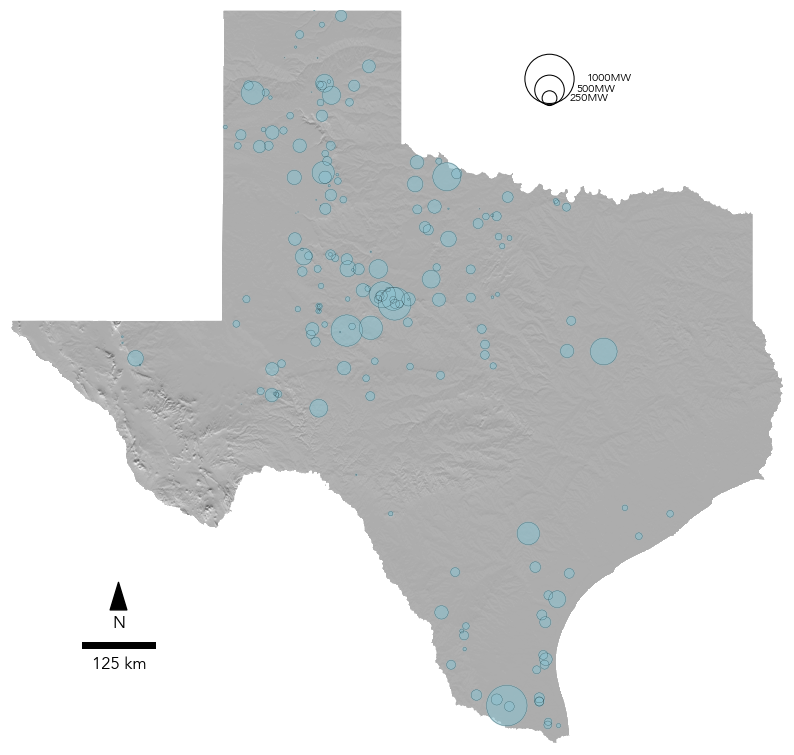

In [13]:
def _hillshade(_ax, shapefile_):

    # Initialize Earth Engine
    ee.Initialize()
    
    # Get the bounding box from 
    bounds = TX_.total_bounds  # [minx, miny, maxx, maxy]
    roi    = geemap.geopandas_to_ee(TX_)  # Convert GeoDataFrame to EE FeatureCollection
    
    _DEM      = ee.Image('USGS/SRTMGL1_003').select('elevation')
    hillshade = ee.Terrain.hillshade(_DEM, 180, 22.5)
    
    # Download hillshade as a NumPy array
    hillshade_np = geemap.ee_to_numpy(hillshade.clip(roi), 
                                      region=roi, 
                                      scale=1000).astype(float)
    hillshade_np[hillshade_np == 0] = np.nan
    
    # Create a colormap and set NaNs (bad values) to transparent
    _cmap = cm.get_cmap("Greys_r").copy()
    _cmap.set_bad(color=(0, 0, 0, 0))  # RGBA: transparent
    
    _ax.imshow(hillshade_np.squeeze(), 
               cmap=_cmap, 
               extent=[bounds[0], bounds[2], bounds[1], bounds[3]], 
               origin='upper', 
               vmin=1)
    
    return _ax

fig, _ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as needed

_ax = _hillshade(_ax, TX_)

TX_.plot(ax        = _ax, 
         facecolor = 'None', 
         edgecolor = 'w')

scale = 50

_ax.scatter(x_ts_[:, 0], x_ts_[:, 1], 
            s     = np.pi * (p_ts_/scale)**2,
            c     = '#8dc0cd', 
            alpha = 0.625)

_ax.scatter(x_ts_[:, 0], x_ts_[:, 1], 
            s         = np.pi * (p_ts_/scale)**2,
            edgecolor = 'k', 
            lw        = .125, 
            facecolor = 'None')

loc_    = [-97.5, 35.5]
sizes_  = np.array([1000, 600, 300])/scale
labels_ = ['1000MW', '500MW', '250MW', ]

for r, label in zip(sizes_, labels_):
    
    _ax.scatter(loc_[0], loc_[1] + (r - sizes_[0])/50, 
                s         = np.pi * r**2,
                edgecolor = 'k', 
                lw        = .75, 
                facecolor = 'None')
    
    _ax.text(loc_[0] + (r - sizes_[0])/50 + .625, 
             loc_[1] + (r - sizes_[0])/50, 
             label, 
             fontsize=8, 
             ha='left', 
             va='center')

# # Add compass (North arrow)
x, y, arrow_length = 0.14, 0.225, 0.06  # relative axes coords

_ax.annotate('N', 
             xy         = (x, y), 
             xytext     = (x, y - arrow_length),
             ha         = 'center', 
             va         = 'center',
             fontsize   = 12,
             xycoords   = _ax.transAxes, 
             arrowprops = dict(facecolor='k', 
                               arrowstyle='wedge,tail_width=1,shrink_factor=.5'))

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'lower left',
                    length_fraction = .10,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 5,
                    font_properties = {'size': 12})

_ax.add_artist(scalebar)

_ax.set_axis_off()

plt.show()

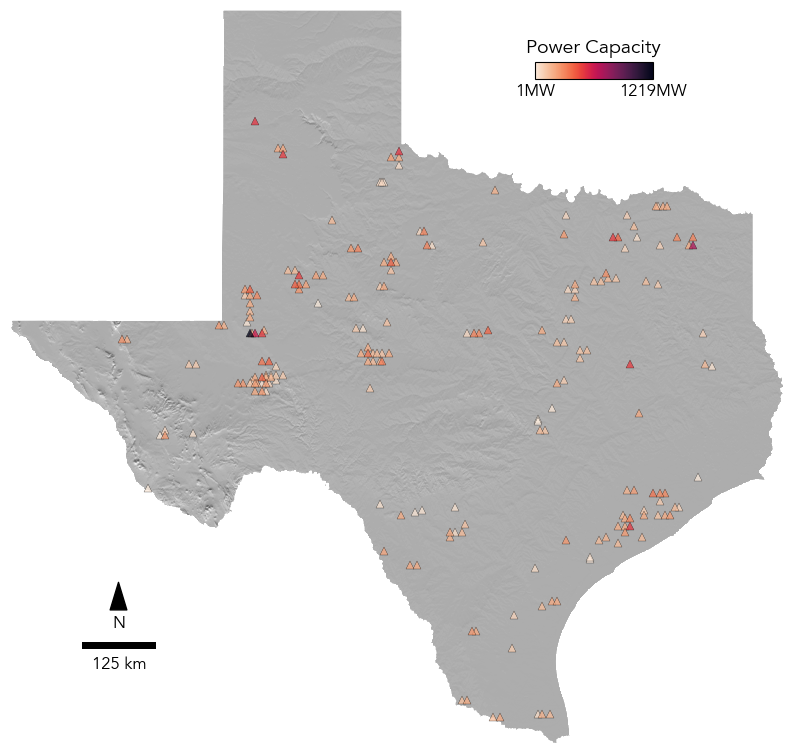

In [15]:
def _spatial_capacity(_fig, _ax, TX_, x_, p_, 
                      cmap = "rocket_r", 
                      marker = 'o'):    
    
    _cmap = sns.color_palette(cmap, as_cmap=True)
    _norm = plt.Normalize(p_.min(), p_.max())
    
    _ax = _hillshade(_ax, TX_)
    
    TX_.plot(ax        = _ax, 
             facecolor = 'None', 
             edgecolor = 'white')
    
    for i in np.arange(x_.shape[0], dtype=int)[np.argsort(p_)]:
        _ax.plot(x_[i, 0], x_[i, 1],
                 c=_cmap(_norm(p_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker=marker,
                 mec="k",
                 mew=.25,
                 zorder=4, 
                 clip_on=False)
    
    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], 
                                            transform = _ax.transData),
                         orientation="horizontal")
    
    cbar.set_ticks([0, 1], 
                   labels=[f"{int(np.around(p_.min(), 0))}MW", 
                           f"{int(np.around(p_.max(), 0))}MW"], 
                   fontsize=12)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Power Capacity", 
                      rotation = 0, 
                      fontsize = 14)
    
    _ax.set_axis_off()

_ax = _hillshade(_ax, TX_)

_fig, _ax = plt.subplots(figsize=(10, 10)) 

_spatial_capacity(_fig, _ax, TX_, x_ts_solar_, p_ts_solar_, 
                  cmap = "rocket_r",
                  marker = '^')    

# Add compass (North arrow)
x, y, arrow_length = 0.14, 0.225, 0.06  # relative axes coords

_ax.annotate('N', 
             xy         = (x, y), 
             xytext     = (x, y - arrow_length),
             ha         = 'center', 
             va         = 'center',
             fontsize   = 12,
             xycoords   = _ax.transAxes, 
             arrowprops = dict(facecolor='k', 
                               arrowstyle='wedge,tail_width=1,shrink_factor=.5'))

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'lower left',
                    length_fraction = .10,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 5,
                    font_properties = {'size': 12})

_ax.add_artist(scalebar)

plt.savefig(path_to_images + f"/{resource}_cap.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

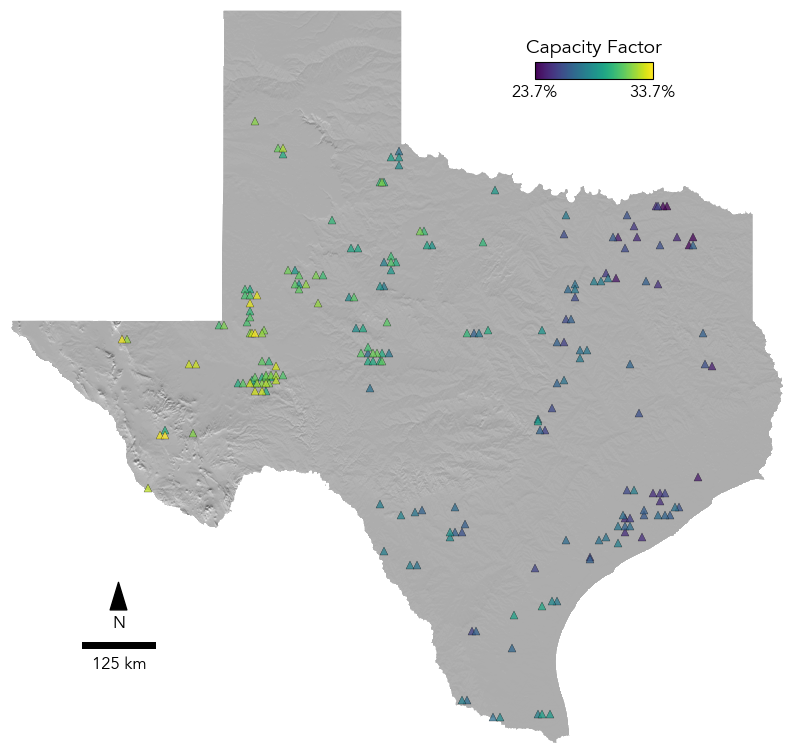

In [16]:
def _spatial_capacity_factors(_fig, _ax, TX_, x_, f_, 
                              cmap = "viridis", 
                              marker = 'o'):
    
    
    _cmap = sns.color_palette(cmap, as_cmap=True)
    _norm = plt.Normalize(f_.min(), f_.max())
    
    _ax = _hillshade(_ax, TX_)

    TX_.plot(ax        = _ax, 
             facecolor = 'None', 
             edgecolor = 'white')
    
    for i in np.arange(x_.shape[0], dtype=int)[np.argsort(f_)]:
        _ax.plot(x_[i, 0], x_[i, 1],
                 c=_cmap(_norm(f_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker=marker,
                 mec="k",
                 mew=.25,
                 zorder=4, 
                 clip_on=False)
    
    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], 
                                            transform = _ax.transData),
                         orientation="horizontal")
    
    cbar.set_ticks([0, 1], 
                   labels=[f"{np.around(100*f_.min(), 1)}%", 
                           f"{np.around(100*f_.max(), 1)}%"], 
                   fontsize=12)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("Capacity Factor", 
                      rotation = 0, 
                      fontsize = 14)
    
    _ax.set_axis_off()

_fig, _ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as neede

f_ts_ = np.mean(np.mean(F_ts_solar_, axis = 0), axis = 0)

_spatial_capacity_factors(_fig, _ax, TX_, x_ts_solar_, f_ts_,
                          cmap = "viridis",
                          marker = '^')

# Add compass (North arrow)
x, y, arrow_length = 0.14, 0.225, 0.06  # relative axes coords

_ax.annotate('N', 
             xy         = (x, y), 
             xytext     = (x, y - arrow_length),
             ha         = 'center', 
             va         = 'center',
             fontsize   = 12,
             xycoords   = _ax.transAxes, 
             arrowprops = dict(facecolor='k', 
                               arrowstyle='wedge,tail_width=1,shrink_factor=.5'))

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'lower left',
                    length_fraction = .10,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 5,
                    font_properties = {'size': 12})

_ax.add_artist(scalebar)

plt.savefig(path_to_images + f"/{resource}_cf.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

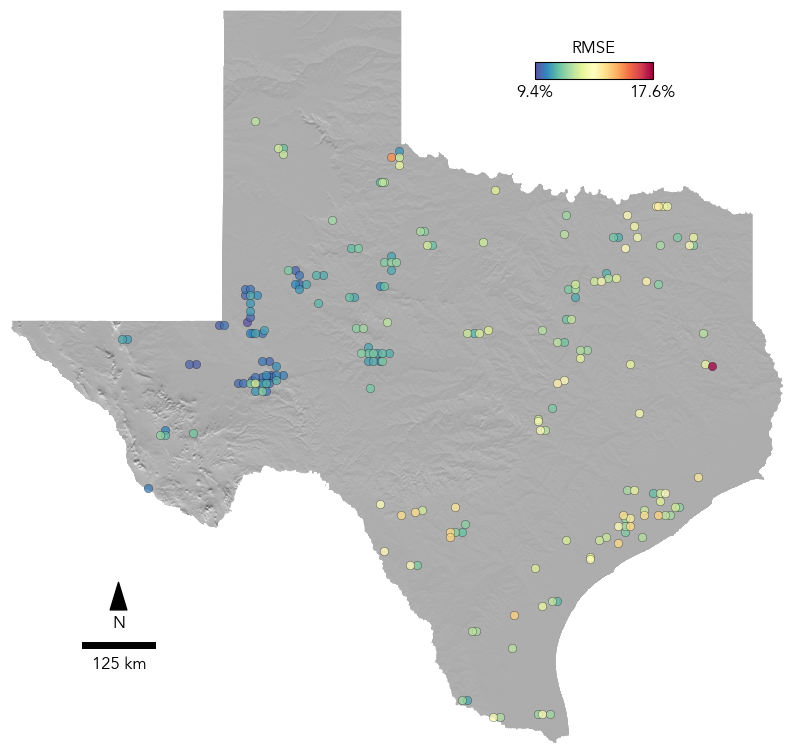

In [38]:
def _spatial_errors(_fig, _ax, TX_, e_, x_, p_, 
                    cmap = "cividis"):
    
    _cmap = sns.color_palette(cmap, as_cmap=True)
    _norm = plt.Normalize(e_.min(), e_.max())

    _ax = _hillshade(_ax, TX_)

    TX_.plot(ax        = _ax, 
             facecolor = 'None', 
             edgecolor = 'white')
    
    for i in np.arange(x_.shape[0], dtype=int)[np.argsort(e_)]:
        _ax.plot(x_[i, 0], x_[i, 1],
                 c=_cmap(_norm(e_[i])),
                 alpha=0.75,
                 ms=6,
                 ls="none",
                 marker="o",
                 mec="k",
                 mew=.25,
                 zorder=4, 
                 clip_on=False)
    
    cbar = _fig.colorbar(cm.ScalarMappable(cmap = _cmap),
                         orientation="horizontal",
                         cax=_ax.inset_axes([-97.75, 35.5, 2.0, 0.25], 
                                            transform = _ax.transData))
    
    cbar.set_ticks([0, 1], 
                   labels=[f"{np.around(100*e_.min(), 1)}%", 
                           f"{np.around(100*e_.max(), 1)}%"], 
                   fontsize=12)
    
    cbar.ax.tick_params(length=0)
    
    cbar.ax.set_title("RMSE", 
                      rotation = 0, 
                      fontsize = 12)


    _ax.set_axis_off()

_fig, _ax = plt.subplots(figsize = (10, 10))  # Adjust figure size as neede

e_ts_ = np.mean(np.sqrt(np.mean((F_ts_ - E_ts_)**2, axis = 0)), axis = 0)

_spatial_errors(_fig, _ax, TX_, e_ts_, x_ts_, p_ts_, 
                cmap = "Spectral_r")

# Add compass (North arrow)
x, y, arrow_length = 0.14, 0.225, 0.06  # relative axes coords

_ax.annotate('N', 
             xy         = (x, y), 
             xytext     = (x, y - arrow_length),
             ha         = 'center', 
             va         = 'center',
             fontsize   = 12,
             xycoords   = _ax.transAxes, 
             arrowprops = dict(facecolor='k', 
                               arrowstyle='wedge,tail_width=1,shrink_factor=.5'))

scalebar = ScaleBar(dx              = 100,  # scaling factor
                    units           = 'km', 
                    dimension       = 'si-length',  # could also be 'imperial-length'
                    location        = 'lower left',
                    length_fraction = .10,  # fraction of the axis for bar length
                    color           = 'black',
                    box_color       = 'None',
                    box_alpha       = 1.,
                    border_pad      = 5,
                    font_properties = {'size': 12})

_ax.add_artist(scalebar)

plt.savefig(path_to_images + f"/{resource}_fce.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

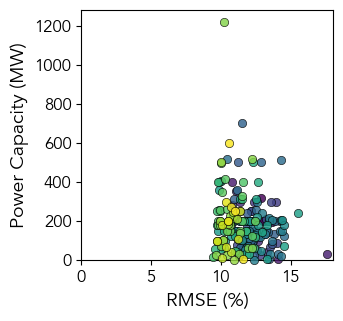

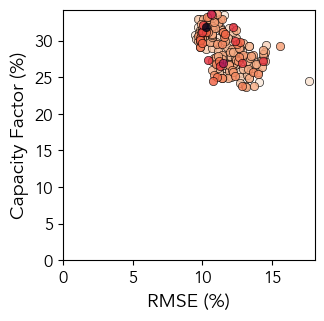

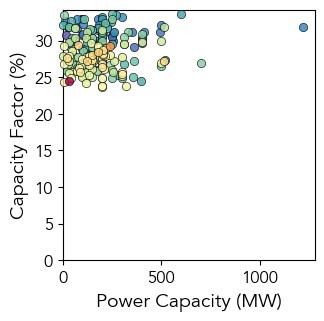

In [39]:
def _scatter_plot(_ax, x_, y_, z_,
                  cmap   = "rocket_r",
                  xlabel = None,
                  ylabel = None):
        
    _cmap = sns.color_palette(cmap, as_cmap=True)
    _norm = plt.Normalize(z_.min(), z_.max())
    
    for i in np.arange(z_.shape[0], dtype=int)[np.argsort(z_)]:
        _ax.plot(x_[i], y_[i],
                 c=_cmap(_norm(z_[i])),
                 alpha=0.825,
                 ms=6,
                 ls="none",
                 marker="o",
                 mec="k",
                 mew=.5,
                 zorder=4, 
                 clip_on=False)

    _ax.tick_params(axis="both", 
                    labelsize=12)
    if xlabel is None:
        _ax.set_xticks([])
    else:
        _ax.set_xlabel(xlabel, size=14)
    
    if ylabel is None:
        _ax.set_yticks([])
    else:
        _ax.set_ylabel(ylabel, size=14)
    
    _ax.set_xlim(0,)
    _ax.set_ylim(0,)

_fig, _ax = plt.subplots(figsize =(3.25, 3.25))  # Adjust figure size as neede

_scatter_plot(_ax, 100.*e_ts_, p_ts_, f_ts_, 
              xlabel = 'RMSE (%)', 
              ylabel = 'Power Capacity (MW)', 
              cmap = 'viridis')

plt.savefig(path_to_images + f"/{resource}_fce_vs_cap.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

_fig, _ax = plt.subplots(figsize=(3.25, 3.25))  # Adjust figure size as neede

_scatter_plot(_ax, 100.*e_ts_, 100.*f_ts_, p_ts_, 
              xlabel = 'RMSE (%)', 
              ylabel = 'Capacity Factor (%)')

plt.savefig(path_to_images + f"/{resource}_fce_vs_cf.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

_fig, _ax = plt.subplots(figsize=(3.25, 3.25))  # Adjust figure size as neede

_scatter_plot(_ax, p_ts_, 100.*f_ts_, 100.*e_ts_, 
              xlabel = 'Power Capacity (MW)', 
              ylabel = 'Capacity Factor (%)',
              cmap = 'Spectral_r')

plt.savefig(path_to_images + f"/{resource}_cap_vs_cf.pdf", 
            bbox_inches="tight", 
            dpi=600)

plt.show()

In [40]:
# fig, ax = plt.subplots(figsize = (10, 2))  # Adjust figure size as needed

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(F_tr_, 97.5, axis = 0), 100.*np.percentile(F_tr_, 2.5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.2)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(F_tr_, 95, axis = 0), 100.*np.percentile(F_tr_, 5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.4)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(F_tr_, 90, axis = 0), 100.*np.percentile(F_tr_, 10, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.4)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(F_tr_, 80, axis = 0), 100.*np.percentile(F_tr_, 10, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.45)

# ax.plot(dt_, 100.*np.median(F_tr_, axis = 0), color = 'k', lw = .25)

# ax.set_ylim(0, 100)
# ax.set_xlim(dt_[0], dt_[-1])
# plt.show()

In [41]:
# f_tr_bar_ = np.mean(F_tr_p_, axis = 2)

# fig, ax = plt.subplots(figsize = (15, 2.5))  # Adjust figure size as needed

# # Fill between the quantiles
# ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 97.5, axis = 0), 100.*np.percentile(f_tr_bar_, 2.5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.2)

# # Fill between the quantiles
# ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 95, axis = 0), 100.*np.percentile(f_tr_bar_, 5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.3)

# # Fill between the quantiles
# ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 90, axis = 0), 100.*np.percentile(f_tr_bar_, 10, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.4)

# # Fill between the quantiles
# ax.fill_between(range(363), 100.*np.percentile(f_tr_bar_, 80, axis = 0), 100.*np.percentile(f_tr_bar_, 20, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.5)

# ax.plot(range(363), 100.*np.median(f_tr_bar_, axis = 0), color = 'k', lw = .125)

# ax.set_ylim(0, 100)
# ax.set_xlim(0, 362)
# plt.show()

In [42]:
# print(F_tr_.shape)

# d = 100
# f_tr_ = F_tr_p_[:, d, :]

# fig, ax = plt.subplots(figsize = (7.5, 2))  # Adjust figure size as needed

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 97.5, axis = 0), 100.*np.percentile(f_tr_, 2.5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.2)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 95, axis = 0), 100.*np.percentile(f_tr_, 5, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.3)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 90, axis = 0), 100.*np.percentile(f_tr_, 10, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.4)

# # Fill between the quantiles
# ax.fill_between(dt_, 100.*np.percentile(f_tr_, 80, axis = 0), 100.*np.percentile(f_tr_, 20, axis = 0), 
#                 color = '#8dc0cd', 
#                 alpha = 0.5)

# ax.plot(dt_, 100.*np.median(f_tr_, axis = 0), color = 'k', lw = .125)

# ax.set_ylim(0, 100)
# ax.set_xlim(dt_[0], dt_[-1])
# plt.show()